<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import OneHotEncoder

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

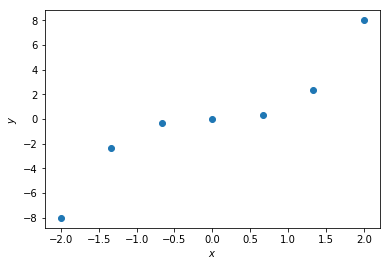

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

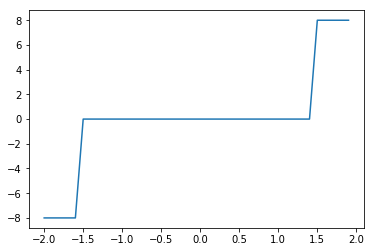

In [3]:
def predict_y(x: float):
    if x < -2 or x > 2: raise Exception()
    if x < -1.5:
        return -8
    elif x > 1.5:
        return 8
    else: 
        return 0
    
def frange(_from, _to, step: float):
    while _from < _to:
        yield _from
        _from += step
        
def show_tree():
    predicted = ((x, predict_y(x)) for x in frange(-2, 2, 0.1))
    _X, _y = zip(*predicted)
    plt.plot(_X, _y)

show_tree()

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

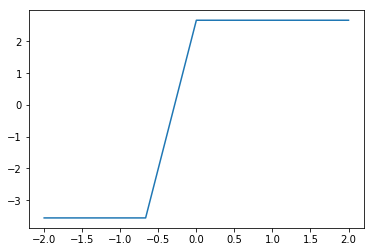

In [4]:
def fit_subtree(X, y, condidion=lambda x: x < 0):
    """ Обучаем мини дерево из 1 ветки 
    
    return: функцию, которая принимает значение x и для него предсказывает, какое среднее значение
    """
    left_part = []
    right_part = []
    for x_i, y_i in zip(X, y):
        if condidion(x_i):
            right_part.append(y_i)
        else:
            left_part.append(y_i)

    left_mean_value = sum(left_part) / len(left_part)
    right_mean_value = sum(right_part) / len(right_part)
    return lambda x: right_mean_value if condidion(x) else left_mean_value

mini_classifier = fit_subtree(X, y)

y_predicted = [mini_classifier(x_i) for x_i in X]
plt.plot(X, y_predicted)

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def regression_var_criterion(X, y, t):
    y_l = [y_i for x_i, y_i in zip(X, y) if x_i < t]
    y_r = [y_i for x_i, y_i in zip(X, y) if x_i >= t]
    
    return D(y) - len(y_l)/len(y)*D(y_l) - len(y_r)/len(y)*D(y_r)

def D(y):
    mean_y = sum(y) * 1/len(y)
    y_squares = [(y_j-mean_y)**2 for y_j in y]
    return sum(y_squares) * 1/len(y)

In [6]:
D([10, 12, 10, 11])

0.6875

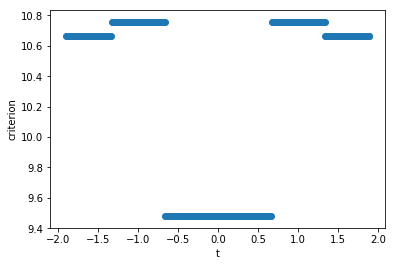

In [7]:
def frange(_from, _to, step: float):
    while _from < _to:
        yield _from
        _from += step
        
criterians = [(t, regression_var_criterion(X, y, t)) for t in frange(-1.9, 1.9, 0.01)]
plt.scatter(*zip(*criterians))
plt.xlabel('t')
plt.ylabel('criterion');

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

### Ответ: да

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [8]:
a = {lambda x: x: 123}

In [9]:
class TreeClassifier:
    def __init__(self, base_tree: dict):
        """
        :param base_tree: example
            tree = {
                lambda x: x >= 0: {
                    'right': {
                        lambda x: x > 1.5: TreeClassifier.get_base_leaf()
                    },
                    'left': {
                        lambda x: x > -1.5: TreeClassifier.get_base_leaf()
                    },
                }
            }
        """
        self.tree = base_tree

    def fit(self, X: list, Y: list):
        'Обучение дерева: для каждого X_i, y_i будем обучать дерево'

        for x_i, y_i in zip(X, Y):
            self.fit_tree(x_i, y_i, self.tree)

    def fit_tree(self, x: float, y: float, tree: dict):
        'Обучение дерева. Два условия: если это не листок - то идем к листку. Если листок - то добавляем y в лист'

        if tree.get('is_leaf', False):
            self.add_value_to_leaf(y, tree)
        else:
            next_tree = self.get_next_tree(x, tree)
            self.fit_tree(x, y, next_tree)

    def add_value_to_leaf(self, y: float, leaf: dict):
        """
        y, который будет добавлен в fit_valuest
        left: {
            'fit_values': [],
            'mean_fit_values': None,
            'is_leaf': True
        }

        При каждом добавлении y в leaf будет перерасчет среднего значения y у листка
        (конечн для больших данных это плохо)
        """

        leaf['fit_values'].append(y)
        leaf['mean_fit_values'] = sum(leaf['fit_values']) / len(leaf['fit_values'])

    def get_next_tree(self, x, tree: dict) -> dict:
        tree_items = list(tree.items())
        if len(tree_items) != 1:
            raise Exception('Head subtree is 1 function')

        get_side_func, subtree_next_dict = tree_items[0]
        if not subtree_next_dict.get('left') or not subtree_next_dict.get('right'):
            raise Exception('subtree_next_dict err: cant get left, or right')

        side = 'right' if get_side_func(x) else 'left'
        return subtree_next_dict[side]

    def predict(self, x: float) -> float:
        next_tree = self.tree
        while not next_tree.get('is_leaf', False):
            next_tree = self.get_next_tree(x, next_tree)
        return next_tree['mean_fit_values']

    @staticmethod
    def get_base_leaf():
        return {
            'left': {
                'fit_values': [],
                'mean_fit_values': None,
                'is_leaf': True
            },
            'right': {
                'fit_values': [],
                'mean_fit_values': None,
                'is_leaf': True
            }
        }

In [10]:
base_tree = {
    lambda x: x >= 0: {
        'right': {
            lambda x: x > 1.5: TreeClassifier.get_base_leaf()
        },
        'left': {
            lambda x: x > -1.5: TreeClassifier.get_base_leaf()
        },
    }
}
model = TreeClassifier(base_tree)
model.fit(X, y)

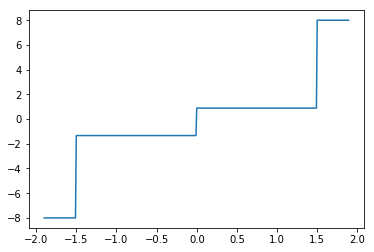

In [11]:
# Посмотрим как обучилась моя модель
myX = list(frange(-1.9, 1.9, 0.01))
predicted = list(map(model.predict, myX))
plt.plot(myX, predicted)

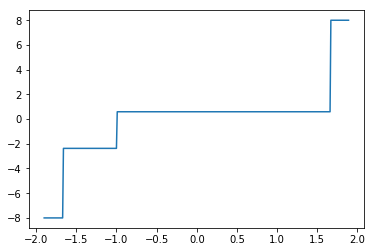

In [12]:
# А теперь skleran-овская

model = DecisionTreeRegressor(max_depth=2)
model.fit(np.array([[x] for x in X]), np.array(y))
predicted = model.predict(np.array([[x] for x in myX]))
plt.plot(myX, predicted);

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

### Ответ 7

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [13]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [14]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [15]:
train_df = df.copy()
train_df['age_years'] = train_df.age.apply(lambda x: x/365)
train_df = pd.concat([
    train_df,
    pd.get_dummies(train_df.cholesterol, prefix='cholesterol'),
    pd.get_dummies(train_df.gluc, prefix='gluc'),
], axis=1)
train_df.drop(['cholesterol', 'gluc', 'age'], axis=1, inplace=True)
train_df.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,0,50.391781,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,1,55.419178,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,1,51.663014,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,1,48.282192,1,0,0,1,0,0
4,1,156,56.0,100,60,0,0,0,0,47.873973,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df.drop(['cardio'], axis=1), train_df.cardio, test_size=0.3, random_state=17,
)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [17]:
model = DecisionTreeRegressor(max_depth=3, random_state=17)
model.fit(X_train, y_train);

In [18]:
import os
if not os.path.exists('files'):
    os.mkdir('files')

classe_names = model.classes_
feature_names = list(X_train.columns)
export_graphviz(
    model, 
    out_file="files/tree.dot", 
    label=list(X_train.columns),
    feature_names=feature_names,
    filled=True, rounded=True, special_characters=True,
#     filled=True,
)
!dot -Tpng files/tree.dot -o files/tree.png
!rm files/tree.dot

<img src='files/tree.png'>

In [19]:
# ap_hi, age_years, cholestrol_3

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

### Ответ: age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [20]:
predicted = map(lambda x: 1 if x >0.5 else 0, model.predict(X_valid))
accuracy_score(y_valid, list(predicted))

0.7212857142857143

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [21]:
tree_params = {'max_depth': list(range(2, 11))}
model = DecisionTreeRegressor()
tree_grid = GridSearchCV(model, tree_params, n_jobs=-1, cv=5)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

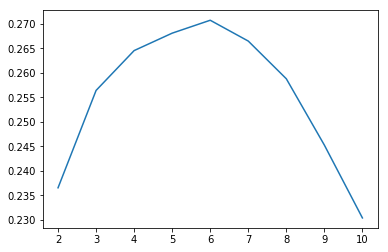

In [22]:
trees_depths = [params['max_depth'] for params in tree_grid.cv_results_['params']]
mean_scores = [mean_score for mean_score in tree_grid.cv_results_['mean_test_score']]
plt.plot(trees_depths, mean_scores);

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [23]:
def get_accuracy(model, X, y):
    predicted = [1 if x>0.5 else 0 for x in model.predict(X)]
    return accuracy_score(y, predicted)

tree_max_depths = list(tree_params['max_depth'])
DecisionTreeRegressor(max_depth=2).fit(X_train, y_train)
fited_trees = [DecisionTreeRegressor(max_depth=depth).fit(X_train, y_train) for depth in tree_max_depths]
accuracies = [get_accuracy(tree, X_valid, y_valid) for tree in fited_trees]

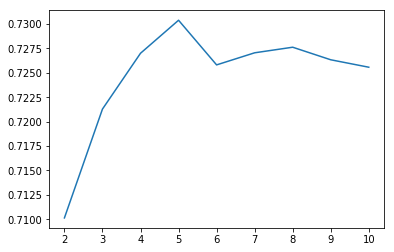

In [24]:
plt.plot(tree_max_depths, accuracies)

In [25]:
print(get_accuracy(tree_grid, X_valid, y_valid))
print(max(accuracies))

0.7258095238095238
0.7303809523809524


In [26]:
# пика по accuracy - имеется
# различие между максимальной accuracy и дерева глуб3 1.25
depth_3_accuracy = accuracies[1]
(max(accuracies) - depth_3_accuracy) / depth_3_accuracy * 100

1.2609757707796854

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

### Ответ: да, да

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [62]:
train_df2 = df.copy()
# train_df2 = df[
#     (train_df.age_years > 45) &
#     (train_df.age_years < 65) &
#     (train_df.ap_hi > 120) &
#     (train_df.ap_hi < 180)
# ].copy()
train_df2['age'] = train_df2.age.apply(lambda x: x/365)
train_df2['is_male'] = train_df2.gender.apply(lambda x: x-1)

def get_category(value, min_value, count_values_in_category):
    return int((value - min_value) // count_values_in_category)

from functools import partial

get_age_category = partial(get_category, min_value=45, count_values_in_category=5)
get_ap_hi_category = partial(get_category, min_value=120, count_values_in_category=20)

train_df2 = pd.concat(
    [
        train_df2,
        pd.get_dummies(train_df2.age.apply(get_age_category), prefix='age'),
        pd.get_dummies(train_df2.ap_hi.apply(get_ap_hi_category), prefix='ap_hi'),
        pd.get_dummies(train_df2.cholesterol, prefix='cholesterol'),
    ],
    axis=1
).drop(['age', 'height', 'ap_hi', 'gender', 'cholesterol', 'weight', 'alco', 'active', 'ap_lo', 'gluc',], axis=1)

train_df2.head()

,smoke,cardio,is_male,age_-4,age_-3,age_-2,age_-1,age_0,age_1,age_2,...,ap_hi_75,ap_hi_94,ap_hi_545,ap_hi_569,ap_hi_644,ap_hi_695,ap_hi_795,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [65]:
X, y = train_df2.drop(['cardio'], axis=1), train_df2.cardio
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17,)
model = DecisionTreeRegressor(max_depth=3, random_state=17)
model.fit(X, y);

In [66]:
len(model.feature_importances_)
sorted(zip(model.feature_importances_, X.columns), key=lambda x: x[0])

[(0.0, 'is_male'),
 (0.0, 'age_-4'),
 (0.0, 'age_-3'),
 (0.0, 'age_-2'),
 (0.0, 'age_-1'),
 (0.0, 'age_0'),
 (0.0, 'age_3'),
 (0.0, 'ap_hi_-14'),
 (0.0, 'ap_hi_-13'),
 (0.0, 'ap_hi_-12'),
 (0.0, 'ap_hi_-11'),
 (0.0, 'ap_hi_-6'),
 (0.0, 'ap_hi_-5'),
 (0.0, 'ap_hi_-3'),
 (0.0, 'ap_hi_-2'),
 (0.0, 'ap_hi_-1'),
 (0.0, 'ap_hi_0'),
 (0.0, 'ap_hi_3'),
 (0.0, 'ap_hi_4'),
 (0.0, 'ap_hi_5'),
 (0.0, 'ap_hi_6'),
 (0.0, 'ap_hi_9'),
 (0.0, 'ap_hi_14'),
 (0.0, 'ap_hi_29'),
 (0.0, 'ap_hi_34'),
 (0.0, 'ap_hi_39'),
 (0.0, 'ap_hi_42'),
 (0.0, 'ap_hi_49'),
 (0.0, 'ap_hi_50'),
 (0.0, 'ap_hi_54'),
 (0.0, 'ap_hi_59'),
 (0.0, 'ap_hi_64'),
 (0.0, 'ap_hi_65'),
 (0.0, 'ap_hi_69'),
 (0.0, 'ap_hi_75'),
 (0.0, 'ap_hi_94'),
 (0.0, 'ap_hi_545'),
 (0.0, 'ap_hi_569'),
 (0.0, 'ap_hi_644'),
 (0.0, 'ap_hi_695'),
 (0.0, 'ap_hi_795'),
 (0.0, 'cholesterol_2'),
 (5.359997079382554e-05, 'smoke'),
 (0.0002814948549415574, 'age_1'),
 (0.0004037728661539479, 'cholesterol_1'),
 (0.00050013157975313, 'age_2'),
 (0.16983741115417916

In [67]:
export_graphviz(
    model, 
    out_file="files/hw3_tree_1.dot", 
    label=list(X.columns),
    feature_names=X.columns,
    filled=True, rounded=True, special_characters=True,
#     filled=True,
)
!dot -Tpng files/hw3_tree_1.dot -o files/hw3_tree_1.png
!rm files/hw3_tree_1.dot;

<img src='files/hw3_tree_1.png'>

### Ответ: Верхнее артериальное давление от 140 до 160 (мм рт.ст.)